# Simple training tutorial

The objective of this tutorial is to show you the basics of the library and how it can be used to simplify the audio processing pipeline.

This page is generated from the corresponding jupyter notebook, that can be found on [this folder](https://github.com/fastaudio/fastaudio/tree/master/docs)

To install the library, just run this cell:

In [ ]:
!pip install git+https://github.com/fastaudio/fastaudio.git

**COLAB USERS: Before you continue and import the lib, go to the `Runtime` menu and select `Restart Runtime`.**

In [3]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

# ESC-50: Dataset for Environmental Sound Classification

In [6]:
#The first time this will download a dataset that is ~650mb
path = untar_data(URLs.ESC50, dest="ESC50")

The audio files are inside a subfolder `audio/`

In [7]:
(path/"audio").ls()

(#2000) [Path('/home/scart/.fastai/data/master/audio/5-198891-A-8.wav'),Path('/home/scart/.fastai/data/master/audio/3-128512-A-47.wav'),Path('/home/scart/.fastai/data/master/audio/4-234879-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/3-100024-A-27.wav'),Path('/home/scart/.fastai/data/master/audio/5-263831-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/1-22804-A-46.wav'),Path('/home/scart/.fastai/data/master/audio/2-117615-A-48.wav'),Path('/home/scart/.fastai/data/master/audio/5-221518-A-21.wav'),Path('/home/scart/.fastai/data/master/audio/2-43802-A-42.wav'),Path('/home/scart/.fastai/data/master/audio/5-194899-D-3.wav')...]

And there's another folder `meta/` with some metadata about all the files and the labels

In [8]:
(path/"meta").ls()

(#2) [Path('/home/scart/.fastai/data/master/meta/esc50.csv'),Path('/home/scart/.fastai/data/master/meta/esc50-human.xlsx')]

Opening the metadata file

In [9]:
df = pd.read_csv(path/"meta"/"esc50.csv")
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Datablock and Basic End to End Training

In [10]:
# Helper function to split the data
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

Creating the Audio to Spectrogram transform from a predefined config.

In [11]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

Creating the Datablock

In [11]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_x=ColReader("filename", pref=path/"audio"), 
                 splitter=CrossValidationSplitter(fold=1),
                 batch_tfms = [a2s],
                 get_y=ColReader("category"))

In [12]:
dbunch = auds.dataloaders(df, bs=64)

Visualizing one batch of data. Notice that the title of each Spectrogram is the corresponding label.

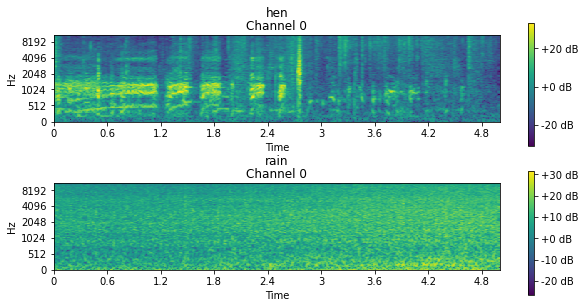

In [15]:
dbunch.show_batch(figsize=(10, 5))

# Learner and Training

While creating the learner, we need to pass a special cnn_config to indicate that our input spectrograms only have one channel. Besides that, it's the usual vision learner.

In [16]:
learn = cnn_learner(dbunch, 
            resnet18, 
            config=cnn_config(n_in=1), #<- Only audio specific modification here
            loss_fn=CrossEntropyLossFlat,
            metrics=[accuracy])

In [17]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,4.559088,2.335686,0.340000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,2.299654,1.825524,0.497500,00:09
1,1.779437,1.425651,0.590000,00:09
2,1.301816,1.242665,0.642500,00:09
3,0.882593,1.107010,0.692500,00:09
4,0.596167,1.014652,0.707500,00:09
5,0.401981,0.997006,0.720000,00:09
6,0.282515,1.003401,0.727500,00:09
7,0.197506,0.973345,0.740000,00:09
8,0.144901,0.970970,0.727500,00:09
9,0.108945,0.977597,0.727500,00:09
